In [1]:
#using POMDPs
using Plots
using DifferentialEquations
using DataStructures

In [2]:
#Global Variables
plot_size = 800; #number of pixels
cart_size = 1; # radius in meters

In [3]:
struct goal_location
    x::Float64
    y::Float64
    id::Float64
end

mutable struct human_state
    x::Float64
    y::Float64
    v::Float64
    goal::goal_location
end

struct obstacle_location
    x::Float64
    y::Float64
    r::Float64 #Radius of the obstacle which is assumed to be a circle
end

mutable struct cart_state
    x::Float64
    y::Float64
    theta::Float64
    v::Float64
    L::Float64
    goal::goal_location
end

In [4]:
mutable struct experiment_environment 
    length::Float64
    breadth::Float64
    num_humans::Float64
    goals::Array{goal_location}
    humans::Array{human_state}
    obstacles::Array{obstacle_location}
    cart::cart_state
end

In [5]:
function Base.show(io::IO, mime::MIME, env::experiment_environment)
    
    #Plot Boundaries
    p = plot([0.0],[0.0],legend=false,grid=false)
    plot!([env.length], [env.breadth],legend=false)
    
    #Plot Humans
    for i in 1: length(env.humans)
        scatter!([env.humans[i].x], [env.humans[i].y],color="red",msize=plot_size/env.length)
    end
    
    #Plot Obstacles
    for i in 1: length(env.obstacles)
        scatter!([env.obstacles[i].x], [env.obstacles[i].y],color="black",shape=:circle,msize=plot_size*env.obstacles[i].r/env.length)
    end
    
    #Plot Golfcart
    scatter!([env.cart.x], [env.cart.y], shape=:sq, color="blue", msize= plot_size*cart_size/env.length)
    
    plot!(size=(plot_size,plot_size))
    show(io, mime, p)
end

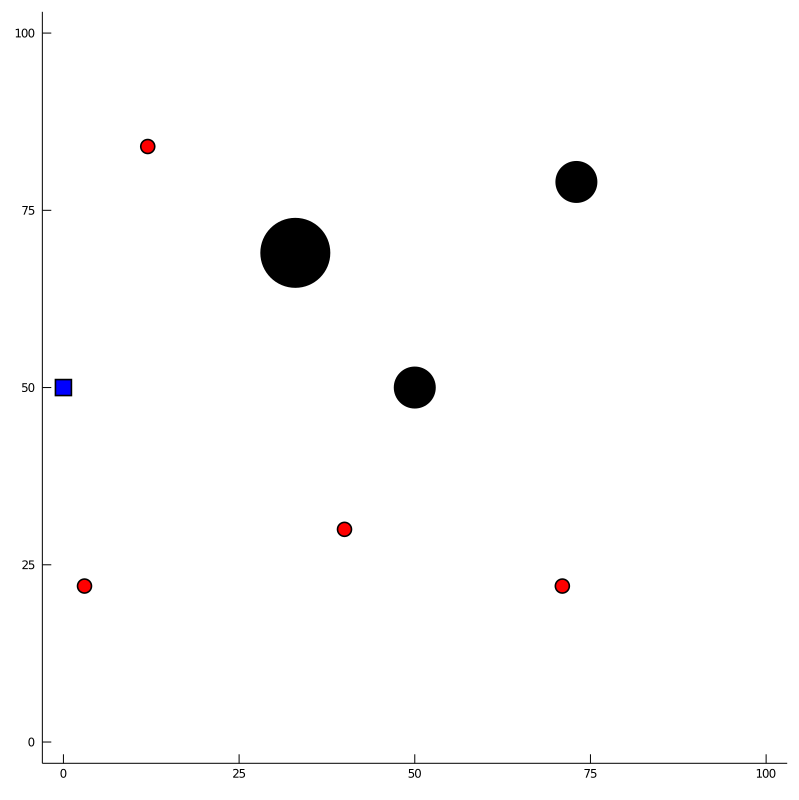

In [6]:
g1 = goal_location(0,0,1)
g2 = goal_location(0,100,2)
g3 = goal_location(0,30,3)
g4 = goal_location(14,1,4)
cart_goal = goal_location(100,50,5)
all_goals_list = [g1,g2,g3,g4]

h1 = human_state(40,30,0.5,g3)
h2 = human_state(3,22,0.5,g4)
h3 = human_state(71,22,0.5,g2)
h4 = human_state(12,84,0.5,g1)
human_state_start_list = [h1,h2,h3,h4]

o1 = obstacle_location(50,50,3)
o2 = obstacle_location(33,69,5)
o3 = obstacle_location(73,79,3)
all_obstacle_list = [o1,o2,o3]

golfcart = cart_state(0,50,0,1,1,cart_goal)

env = experiment_environment(100,100,4,all_goals_list,human_state_start_list,all_obstacle_list,golfcart)

In [7]:
#Integration

function wrap_between_0_and_2Pi(theta)
   return mod(theta,2*pi) 
end

function travel!(du,u,p,t)
    x,y,theta = u
    v,L,alpha = p 
    
    du[1] = v*cos(theta)
    du[2] = v*sin(theta)
    du[3] = (v/L)*tan(alpha)
end

function get_intermediate_points(initial_state, time_interval, extra_parameters)
    prob = ODEProblem(travel!,initial_state,time_interval,extra_parameters)
    sol = solve(prob,saveat=0.1)
    x = []
    y = []
    theta = []
    
    for i in 1:length(sol.u)
        push!(x,sol.u[i][1])
        push!(y,sol.u[i][2])
        push!(theta,wrap_between_0_and_2Pi(sol.u[i][3]))
    end
    
    return x,y,theta
end

# x_init = 0.0;
# y_init = 50.0;
# theta_init = -pi/6;
# cart_current_speed = 1.0
# cart_length = 1.0
# steering_angle = -pi/10

# initial_state = [x_init,y_init,theta_init]
# extra_parameters = [cart_current_speed, cart_length, steering_angle]
# time_interval = (0.0,1.0)

# x,y,theta = get_intermediate_points(initial_state, time_interval, extra_parameters);
# theta

In [8]:
# x_init = 0.0;
# y_init = 50.0;
# theta_init = 0.0;
# cart_current_speed = 1.0
# cart_length = 1.0
# time_interval = (0.0,1.0)

# initial_state = [x_init,y_init,theta_init]

# lala_path = [10,20,30,40,50,60]

# anim = @animate for i ∈ 1:length(lala_path)
#         env.cart.x = lala_path[i]
#         env.cart.y = lala_path[i]
#         display(env);
# end
# gif(anim, "anim_fps15.gif", fps = 1)

In [9]:
# x_init = 0.0;
# y_init = 50.0;
# theta_init = 0.0;
# cart_current_speed = 1.0
# cart_length = 1.0
# time_interval = (0.0,1.0)

# initial_state = [x_init,y_init,theta_init]



# anim = @animate for i ∈ 1:length(path_x)
#     #@show(initial_state)
#     env.cart.x = path_x[i]
#     env.cart.y = path_y[i]
#     display(env);
# end
# gif(anim, "paths.gif", fps = 1000)

In [10]:
pq = PriorityQueue(Base.Order.Reverse);
pq["a"] = 10; pq["b"] = 15; pq["c"] = 15; 
#pq;
display(pq)

PriorityQueue{Any,Any,Base.Order.ReverseOrdering{Base.Order.ForwardOrdering}} with 3 entries:
  "b" => 15
  "c" => 15
  "a" => 10

In [11]:
mutable struct graph_node
    x::Float64
    y::Float64
    theta::Float64
    actual_cost::Float64
    heuristic_cost::Float64
    action_taken_to_reach_here::Float64
    discrete_x::Float64
    discrete_y::Float64
    parent::Any
end

#null_graph_node = graph_node(-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,nothing)

In [16]:
function hybrid_a_star_search(start_x, start_y, start_theta, goal_x, goal_y, env)
    
    #Action Set
    #set_of_delta_angles = [0,-pi/180,pi/180,-pi/90,pi/90,-pi/360,pi/360]
    set_of_delta_angles = [0,-pi/18,pi/18,-pi/9,pi/9,-pi/6,pi/6]
    #delta_t = 1 second
    time_step = 1
    #Radius of circle around goal = 1m
    radius_around_goal_threshold = 1
    #Obstacle collision threshold
    obstacle_collision_threshold = 10
    #Human collision threshold
    human_collision_threshold = 10
    #Distance covered in one time interval
    arc_length = 1
    
    function is_goal(node, goal_x, goal_y, threshold)
        euclidean_distance =  ( (node.x - goal_x)^2 + (node.y - goal_y)^2 )^ 0.5
        if(euclidean_distance < threshold)
            return true
        else
            return false
        end
    end
    
    function calculate_heuristic_cost(node_x, node_y, goal_x, goal_y)
        euclidean_distance =  ( (node_x - goal_x)^2 + (node_y - goal_y)^2 )^ 0.5
        return euclidean_distance
    end
    
    function get_path(current_node)
        steering_angle_controls_sequence = [] 
        while(current_node!= nothing)
            push!(steering_angle_controls_sequence, current_node.action_taken_to_reach_here)
#             @show(current_node.x,current_node.y)
#             @show("*****************")
            current_node = current_node.parent
        end
        return reverse(steering_angle_controls_sequence)
    end     
    
    function get_action_cost(environment, x, y, discrete_x, discrete_y, obs_thresold, hum_threshold, action)
        total_cost = 0

        #Cost from going out of bounds
        for i in 1:length(x)
            if(x[i]<0 || x[i]>env.length)
                return Inf
            end
            if(y[i]<0 || y[i]>env.breadth)
                return Inf
            end
        end
        
        final_x = last(x)
        final_y = last(y)
        #Cost from obstacles
        for obstacle in environment.obstacles
            euclidean_distance = ( (final_x - obstacle.x)^2 + (final_y - obstacle.y)^2 )^ 0.5
            if(euclidean_distance >= obstacle.r + 5)
                continue
            elseif(euclidean_distance <= obstacle.r)
                total_cost = Inf
            else
                distance_between_cart_and_obstacle = euclidean_distance - obstacle.r
                total_cost += obs_thresold* (5 - distance_between_cart_and_obstacle) 
            end
        end
        
        #Cost from humans
        for human in environment.humans
            euclidean_distance = ( (final_x - human.x)^2 + (final_y - human.y)^2 )^ 0.5
            if(euclidean_distance >= 1 + 5)
                continue
            elseif(euclidean_distance <= 1)
                total_cost = Inf
            else
                total_cost += hum_threshold * (5 + 1 - euclidean_distance) 
            end
        end
        
        #Cost from no change in steering angle 
        if(action == 0)
           total_cost += -0.1 
        end
#         #Cost from Long Paths
        total_cost += 1
        
        return total_cost
        
    end
    
    function get_discrete_state(environment, x, y)
        discretization_width = 0.4
        max_num_bins_x = ceil(environment.length/discretization_width)
        discrete_x = clamp(ceil(x/discretization_width),1,max_num_bins_x)
        max_num_bins_y = ceil(environment.breadth/discretization_width)
        discrete_y = clamp(ceil(y/discretization_width),1,max_num_bins_y)
        return discrete_x,discrete_y
    end
    
    open = PriorityQueue(Base.Order.Forward);
    closed = Dict()
    dict_of_nodes = Dict()
    start_theta = wrap_between_0_and_2Pi(start_theta)
    start_discrete_x, start_discrete_y = get_discrete_state(env,start_x,start_y)
    
    start_node = graph_node(start_x, start_y, start_theta, 0, 
        calculate_heuristic_cost(start_x,start_y,goal_x,goal_y), 0, start_discrete_x, start_discrete_y,nothing)
    
    node_key = "x"*string(start_node.discrete_x)*"y"*string(start_node.discrete_y)
    open[node_key] = start_node.actual_cost + start_node.heuristic_cost
    dict_of_nodes[node_key] = start_node
    
    while(length(open) != 0)
        current_node = dict_of_nodes[dequeue!(open)]
        if(is_goal(current_node, goal_x, goal_y, radius_around_goal_threshold))
            path = get_path(current_node)
            return path
        end
        
        node_key = "x"*string(current_node.discrete_x)*"y"*string(current_node.discrete_y)
        closed[node_key] = current_node
        current_state = [current_node.x,current_node.y,current_node.theta]
        
        
        @show("Current Node")
        @show(current_state)
        
        for delta in set_of_delta_angles
            delta = wrap_between_0_and_2Pi(delta)
            steering_angle = atan((env.cart.L*delta)/arc_length)
            @show("For new angle" * " " * string(steering_angle) * " " * string(delta))
            extra_parameters = [arc_length, env.cart.L, steering_angle]
            time_interval = (0.0,time_step)
            x,y,theta = get_intermediate_points(current_state, time_interval, extra_parameters)
            final_x,final_y,final_theta = last(x), last(y), last(theta)
            discrete_x, discrete_y = get_discrete_state(env,final_x,final_y)
            node_key = "x"*string(discrete_x)*"y"*string(discrete_y)
            if(haskey(closed,node_key))
                continue
            end
            g = current_node.actual_cost + get_action_cost(env, x, y, discrete_x, discrete_y, obstacle_collision_threshold, human_collision_threshold, steering_angle)
            h = calculate_heuristic_cost(final_x, final_y, goal_x, goal_y)
            new_node = graph_node(final_x, final_y, final_theta, g, h, 
                steering_angle, discrete_x, discrete_y, current_node)
            @show(final_x,final_y,final_theta,discrete_x,discrete_y,g,h)
            if(new_node.actual_cost == Inf)
                closed[node_key] = new_node
                continue
            end
            if(haskey(open,node_key))
                if(dict_of_nodes[node_key].actual_cost > new_node.actual_cost)
                    dict_of_nodes[node_key] = new_node
                    open[node_key] = new_node.heuristic_cost + new_node.actual_cost
                end
            else
                dict_of_nodes[node_key] = new_node
                open[node_key] = new_node.heuristic_cost + new_node.actual_cost
            end
        end
        @show("The open list is ")
        @show(open.xs)
    end
    
    return nothing
    
end

hybrid_a_star_search (generic function with 1 method)

In [17]:
x_init = 0.0;
y_init = 50.0;
theta_init = 0.0;
cart_current_speed = 1.0
cart_length = 1.0
time_interval = (0.0,1.0)

(0.0, 1.0)

In [18]:
returned_path = hybrid_a_star_search(x_init, y_init, theta_init, 100, 50, env);
length(returned_path)

"Current Node" = "Current Node"
current_state = [0.0, 50.0, 0.0]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 0.9999999999999998
final_y = 50.0
final_theta = 0.0
discrete_x = 3.0
discrete_y = 125.0
g = 0.9
h = 99.0
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = -0.028427381416586593
final_y = 50.002488085491066
final_theta = 6.108652381980154
discrete_x = 1.0
discrete_y = 126.0
g = Inf
h = 100.02842741236064
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 0.9949307700442935
final_y = 50.08704516331335
final_theta = 0.1745329251994329
discrete_x = 3.0
discrete_y = 126.0
g = 1.0
h = 99.00510749496098
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(stee

"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x13.0y125.0" => 99.5, "x10.0y126.0" => 99.70510869067967, "x13.0y126.0" => 99.60510910603337, "x3.0y126.0" => 100.00510749496098, "x8.0y126.0" => 99.80510828388951, "x5.0y126.0" => 99.90510788540077]
"Current Node" = "Current Node"
current_state = [4.999999999999999, 50.0, 0.0]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 5.999999999999999
final_y = 50.0
final_theta = 0.0
discrete_x = 15.0
discrete_y = 125.0
g = 5.4
h = 94.0
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 4.971586647179873
final_y = 50.0024998695844
final_theta = 6.108652381980154
discrete_x = 13.0
discrete_y = 126.0
g = 5.5
h = 95.0284133857016
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 5.994930770043369
final_y = 50

final_y = 50.00250707000574
final_theta = 6.1086523819801535
discrete_x = 23.0
discrete_y = 126.0
g = 9.100000000000001
h = 91.02842424403435
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 9.994930770043368
final_y = 50.08704516328759
final_theta = 0.17453292519943286
discrete_x = 25.0
discrete_y = 126.0
g = 9.100000000000001
h = 90.00511132124518
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
final_x = 8.942366840468017
final_y = 50.01018291457685
final_theta = 5.934119456780723
discrete_x = 23.0
discrete_y = 126.0
g = 9.100000000000001
h = 91.05763372890627
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 9.979815536078148
final_y = 50.17276791481533
final_theta = 0.3490658503988659
discrete_x = 25.0
discrete_y = 126.0
g = 9.100000000000

final_x = 12.954929659127409
final_y = 50.25587262195364
final_theta = 0.5235987755982986
discrete_x = 33.0
discrete_y = 126.0
g = 11.800000000000002
h = 87.04544641419288
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x33.0y125.0" => 98.7, "x25.0y126.0" => 99.10511132124518, "x33.0y126.0" => 98.80511277258364, "x18.0y126.0" => 99.40510996353629, "x23.0y126.0" => 99.20511085872953, "x28.0y126.0" => 99.00511179415385, "x30.0y126.0" => 98.90511227780982, "x3.0y126.0" => 100.00510749496098, "x10.0y126.0" => 99.70510869067967, "x8.0y126.0" => 99.80510828388951, "x20.0y126.0" => 99.305110406268, "x5.0y126.0" => 99.90510788540077, "x15.0y126.0" => 99.50510953022389, "x13.0y126.0" => 99.60510910603337]
"Current Node" = "Current Node"
current_state = [12.999999999999998, 50.0, 0.0]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 13.999999999999998
final_y = 50.0
final_theta = 0.0
discrete_x = 35.0
discrete_y = 125.0
g

final_theta = 0.3490658503988659
discrete_x = 43.0
discrete_y = 126.0
g = 15.400000000000004
h = 83.02036423177148
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.759586531581287"
final_x = 15.913201194768225
final_y = 50.02327855350285
final_theta = 5.759586531581284
discrete_x = 40.0
discrete_y = 126.0
g = 15.400000000000004
h = 84.08680202744414
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
final_x = 16.95492965912741
final_y = 50.25587262195388
final_theta = 0.5235987755982986
discrete_x = 43.0
discrete_y = 126.0
g = 15.400000000000004
h = 83.04546452828802
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x43.0y125.0" => 98.30000000000001, "x43.0y126.0" => 98.40511487089422, "x35.0y126.0" => 98.70511327886317, "x40.0y126.0" => 98.5051143275828, "x23.0y126.0" => 99.20511085872953, "x28.0y126.0" => 99.00511179415385, "x33.0y126.0

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 19.971580754763963
final_y = 50.002508587589034
final_theta = 6.1086523819801535
discrete_x = 50.0
discrete_y = 126.0
g = 19.0
h = 80.0284192845534
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 20.994930770043368
final_y = 50.08704516328758
final_theta = 0.1745329251994329
discrete_x = 53.0
discrete_y = 126.0
g = 19.0
h = 79.00511718167812
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
final_x = 19.942376493006392
final_y = 50.01018300476171
final_theta = 5.934119456780723
discrete_x = 50.0
discrete_y = 126.0
g = 19.0
h = 80.05762415461204
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 20.979815536078146

final_y = 50.2558726219541
final_theta = 0.5235987755982986
discrete_x = 60.0
discrete_y = 126.0
g = 21.699999999999996
h = 76.04550081330865
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x60.0y125.0" => 97.6, "x55.0y126.0" => 97.90511779640346, "x60.0y126.0" => 97.70511907438177, "x43.0y126.0" => 98.40511487089422, "x53.0y126.0" => 98.00511718167812, "x58.0y126.0" => 97.80511842709461, "x33.0y126.0" => 98.80511277258364, "x25.0y126.0" => 99.10511132124518, "x40.0y126.0" => 98.5051143275828, "x45.0y126.0" => 98.30511542745631, "x50.0y126.0" => 98.10511658231994, "x35.0y126.0" => 98.70511327886317, "x15.0y126.0" => 99.50510953022389, "x13.0y126.0" => 99.60510910603337, "x30.0y126.0" => 98.90511227780982, "x3.0y126.0" => 100.00510749496098, "x18.0y126.0" => 99.40510996353629, "x10.0y126.0" => 99.70510869067967, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x20.0y126.0" => 99.305110406268, "x48.0y126.0" => 

"Current Node" = "Current Node"
current_state = [26.999999999999996, 50.0, 0.0]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 27.999999999999996
final_y = 50.0
final_theta = 0.0
discrete_x = 70.0
discrete_y = 125.0
g = 25.19999999999999
h = 72.0
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 26.971587308029925
final_y = 50.00251150955263
final_theta = 6.108652381980155
discrete_x = 68.0
discrete_y = 126.0
g = 25.29999999999999
h = 73.02841273515655
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 27.994930770043364
final_y = 50.08704516328757
final_theta = 0.1745329251994329
discrete_x = 70.0
discrete_y = 126.0
g = 25.29999999999999
h = 72.00512184331959
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 30.994930770043364
final_y = 50.08704516328756
final_theta = 0.1745329251994329
discrete_x = 78.0
discrete_y = 126.0
g = 27.999999999999986
h = 69.00512413068728
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
final_x = 29.942381877700175
final_y = 50.010188544177836
final_theta = 5.9341194567807225
discrete_x = 75.0
discrete_y = 126.0
g = 27.999999999999986
h = 70.05761886316454
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 30.979815536078142
final_y = 50.172767914815374
final_theta = 0.3490658503988659
discrete_x = 78.0
discrete_y = 126.0
g = 27.999999999999986
h = 69.02040069563628
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.7

discrete_y = 125.0
g = 30.59999999999998
h = 66.0
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 32.97159013965192
final_y = 50.00251507540583
final_theta = 6.108652381980154
discrete_x = 83.0
discrete_y = 126.0
g = 30.69999999999998
h = 67.02840990753407
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 33.99493077004336
final_y = 50.08704516328756
final_theta = 0.17453292519943292
discrete_x = 85.0
discrete_y = 126.0
g = 30.69999999999998
h = 66.00512662598126
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
final_x = 32.94238267326325
final_y = 50.01019043523441
final_theta = 5.934119456780723
discrete_x = 83.0
discrete_y = 126.0
g = 30.69999999999998
h = 67.05761810103334
"For new angle" * " " * string(steering_angle) * " " * string(delta

final_theta = 0.0
discrete_x = 93.0
discrete_y = 125.0
g = 33.299999999999976
h = 63.00000000000001
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 35.97159101286157
final_y = 50.00251692857746
final_theta = 6.108652381980154
discrete_x = 90.0
discrete_y = 126.0
g = 33.39999999999998
h = 64.0284090366081
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 36.99493077004336
final_y = 50.08704516328757
final_theta = 0.1745329251994329
discrete_x = 93.0
discrete_y = 126.0
g = 33.39999999999998
h = 63.00512935890284
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
final_x = 35.94238324839673
final_y = 50.01019231531594
final_theta = 5.934119456780723
discrete_x = 90.0
discrete_y = 126.0
g = 33.39999999999998
h = 64.05761756246149
"For new angle" * "

"Current Node" = "Current Node"
current_state = [38.99999999999999, 50.0, 0.0]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 39.99999999999999
final_y = 50.0
final_theta = 0.0
discrete_x = 100.0
discrete_y = 125.0
g = 35.99999999999997
h = 60.00000000000001
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 38.97159163754302
final_y = 50.002518768350384
final_theta = 6.108652381980154
discrete_x = 98.0
discrete_y = 126.0
g = 36.09999999999997
h = 61.02840841443436
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 39.99493077004336
final_y = 50.08704516328756
final_theta = 0.17453292519943286
discrete_x = 100.0
discrete_y = 126.0
g = 36.09999999999997
h = 60.005132365093075
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4

"Current Node" = "Current Node"
current_state = [41.99999999999999, 50.0, 0.0]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 42.99999999999999
final_y = 50.0
final_theta = 0.0
discrete_x = 108.0
discrete_y = 125.0
g = 48.699999999999896
h = 57.00000000000001
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
final_x = 41.97159206910106
final_y = 50.002520571820796
final_theta = 6.108652381980154
discrete_x = 105.0
discrete_y = 126.0
g = 38.79999999999997
h = 58.028407985641806
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 42.99493077004337
final_y = 50.08704516328756
final_theta = 0.1745329251994329
discrete_x = 108.0
discrete_y = 126.0
g = 48.74389978243365
h = 57.00513568769571
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.

final_y = 50.927331522593065
final_theta = 0.5235987755982988
discrete_x = 107.0
discrete_y = 128.0
g = 46.264462767517536
h = 57.21163067908299
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 42.747972613761945
final_y = 51.00018023026605
final_theta = 0.6981317007977317
discrete_x = 107.0
discrete_y = 128.0
g = 45.79326417346431
h = 57.26076318324414
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 42.69202106331561
final_y = 51.0668606900842
final_theta = 0.8726646259971648
discrete_x = 107.0
discrete_y = 128.0
g = 45.14558383477009
h = 57.31790855866523
"For new angle

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
final_x = 39.89092108974367
final_y = 50.504852268933824
final_theta = 0.6981317007977316
discrete_x = 100.0
discrete_y = 127.0
g = 36.199999999999974
h = 60.11119898365753
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x105.0y128.0" => 96.2115015645978, "x100.0y127.0" => 96.27166009895853, "x75.0y126.0" => 97.10512334644852, "x93.0y126.0" => 96.40512935890283, "x95.0y126.0" => 96.30513032864428, "x63.0y126.0" => 97.60511973892875, "x73.0y126.0" => 97.20512258429939, "x80.0y126.0" => 96.90512493799011, "x90.0y126.0" => 96.50512841946332, "x45.0y126.0" => 98.30511542745631, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x60.0y126.0" => 97.70511907438177, "x65.0y126.0" => 97.50512042143521, "x70.0y126.0" => 97.30512184331957, "x43.0y126.0" => 98.40511487089422, "x78.0y126.0" => 97.00512413068726, "x83.0y126.0" => 96.80

open.xs = Pair{Any,Any}["x102.0y128.0" => 96.311376810969, "x98.0y127.0" => 96.37163521060951, "x75.0y126.0" => 97.10512334644852, "x90.0y126.0" => 96.50512841946332, "x93.0y126.0" => 96.40512935890283, "x63.0y126.0" => 97.60511973892875, "x73.0y126.0" => 97.20512258429939, "x80.0y126.0" => 96.90512493799011, "x88.0y126.0" => 96.60512750892735, "x45.0y126.0" => 98.30511542745631, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x60.0y126.0" => 97.70511907438177, "x65.0y126.0" => 97.50512042143521, "x70.0y126.0" => 97.30512184331957, "x43.0y126.0" => 98.40511487089422, "x78.0y126.0" => 97.00512413068726, "x83.0y126.0" => 96.80512576938969, "x85.0y126.0" => 96.70512662598125, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x48.0y126.0" => 98.20511599775979, "x5.0y126.0" => 99.90510788540077, "x28.0y126.0" => 99.00511179415385, "x15.0y126.0" => 99.50510953022389, "x58.0y126.0" => 97.80511842709461, "x13.0y

open.xs = Pair{Any,Any}["x93.0y126.0" => 96.40512935890283, "x90.0y126.0" => 96.50512841946332, "x100.0y128.0" => 96.41125620094587, "x88.0y126.0" => 96.60512750892735, "x104.0y129.0" => 96.56295395516517, "x75.0y126.0" => 97.10512334644852, "x73.0y126.0" => 97.20512258429939, "x80.0y126.0" => 96.90512493799011, "x85.0y126.0" => 96.70512662598125, "x45.0y126.0" => 98.30511542745631, "x104.0y130.0" => 96.62765938838271, "x106.0y131.0" => 97.38363775319613, "x60.0y126.0" => 97.70511907438177, "x65.0y126.0" => 97.50512042143521, "x70.0y126.0" => 97.30512184331957, "x43.0y126.0" => 98.40511487089422, "x78.0y126.0" => 97.00512413068726, "x83.0y126.0" => 96.80512576938969, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x63.0y126.0" => 97.60511973892875, "x28.0y126.0" => 99.00511179415385, "x15.0y126.0" => 99.50510953022389, "x58.0y126.0" => 97.80511842709461, "

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 38.795885277307235
final_y = 50.927331522593065
final_theta = 0.5235987755982988
discrete_x = 97.0
discrete_y = 128.0
g = 35.299999999999976
h = 61.21113953147198
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 38.747972613761945
final_y = 51.00018023026604
final_theta = 0.6981317007977317
discrete_x = 97.0
discrete_y = 128.0
g = 35.39999999999998
h = 61.26019277979357
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 38.69202106331564
final_y = 51.066860690084134
final

h = 60.35496912377594
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 39.61399801754639
final_y = 51.50018023026604
final_theta = 0.6981317007977317
discrete_x = 100.0
discrete_y = 129.0
g = 36.299999999999976
h = 60.40463373076748
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 39.55804646710007
final_y = 51.56686069008415
final_theta = 0.8726646259971647
discrete_x = 99.0
discrete_y = 129.0
g = 36.299999999999976
h = 60.462259296981
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.759586531581287"
"For new angle

open.xs = Pair{Any,Any}["x93.0y127.0" => 96.57158780151067, "x88.0y126.0" => 96.60512750892735, "x102.0y130.0" => 96.60328556577828, "x85.0y126.0" => 96.70512662598125, "x106.0y131.0" => 96.84622742910446, "x104.0y131.0" => 96.65414912473352, "x73.0y126.0" => 97.20512258429939, "x80.0y126.0" => 96.90512493799011, "x83.0y126.0" => 96.80512576938969, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x106.0y132.0" => 96.70813623103592, "x101.0y131.0" => 96.8769276915065, "x65.0y126.0" => 97.50512042143521, "x70.0y126.0" => 97.30512184331957, "x43.0y126.0" => 98.40511487089422, "x78.0y126.0" => 97.00512413068726, "x75.0y126.0" => 97.10512334644852, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x99.0y130.0" => 96.82691256121943, "x102.0y131.0" => 96.7535753156674, "x105.0y132.0" => 97.17639103753594, "x58.0y126.0" => 97.80511842709461, 

final_x = 35.89092108974363
final_y = 50.50485226893426
final_theta = 0.6981317007977316
discrete_x = 90.0
discrete_y = 127.0
g = 32.59999999999998
h = 64.11106670875884
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x95.0y128.0" => 96.61102661254446, "x85.0y126.0" => 96.70512662598125, "x104.0y131.0" => 96.65414912473352, "x83.0y126.0" => 96.80512576938969, "x106.0y131.0" => 96.84622742910446, "x104.0y132.0" => 96.65628430367178, "x73.0y126.0" => 97.20512258429939, "x80.0y126.0" => 96.90512493799011, "x75.0y126.0" => 97.10512334644852, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x102.0y131.0" => 96.7535753156674, "x90.0y127.0" => 96.67156520685775, "x65.0y126.0" => 97.50512042143521, "x70.0y126.0" => 97.30512184331957, "x43.0y126.0" => 98.40511487089422, "x78.0y126.0" => 97.00512413068726, "x105.0y132.0" => 97.17639103753594, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 39.42407187088452
final_y = 52.066860690084134
final_theta = 0.8726646259971647
discrete_x = 99.0
discrete_y = 131.0
g = 36.299999999999976
h = 60.61117868690543
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.759586531581287"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
final_x = 39.360967726042965
final_y = 52.12638851652449
final_theta = 1.0471975511965974
discrete_x = 99.0
discrete_y = 131.0
g = 36.299999999999976
h = 60.67630314418645
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x104.0y132.0" => 96.65628430367178, "x85.0y126.0" => 96.70512662598125, "x90.0y127.0" => 96.67156520685775, "x83.0y126.0" => 96.80512576938969, "x106.0y131.0" => 96.84622742910446, "x99.0y130.0" => 96.7027695312603

h = 59.655442042917215
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 40.34604882511527
final_y = 52.50018023026603
final_theta = 0.6981317007977317
discrete_x = 101.0
discrete_y = 132.0
g = 37.199999999999974
h = 59.70632120604438
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 40.29009727466895
final_y = 52.566860690084155
final_theta = 0.8726646259971648
discrete_x = 101.0
discrete_y = 132.0
g = 37.199999999999974
h = 59.765050466562776
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.759586531581287"
"For new

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 37.661910681091676
final_y = 51.42733152259305
final_theta = 0.5235987755982988
discrete_x = 95.0
discrete_y = 129.0
g = 34.39999999999998
h = 62.354427711330814
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 37.61399801754639
final_y = 51.50018023026602
final_theta = 0.6981317007977318
discrete_x = 95.0
discrete_y = 129.0
g = 34.49999999999998
h = 62.40403660083206
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
final_x = 37.55804646710009
final_y = 51.56686069008409
final_th

open.xs = Pair{Any,Any}["x95.0y129.0" => 96.75442771133079, "x83.0y126.0" => 96.80512576938969, "x101.0y132.0" => 96.7554420429172, "x101.0y131.0" => 96.8769276915065, "x106.0y131.0" => 96.84622742910446, "x99.0y129.0" => 96.76225929698097, "x73.0y126.0" => 97.20512258429939, "x80.0y126.0" => 96.90512493799011, "x75.0y126.0" => 97.10512334644852, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x99.0y131.0" => 96.85302045345227, "x88.0y127.0" => 96.77154330665272, "x103.0y133.0" => 97.21986162147265, "x70.0y126.0" => 97.30512184331957, "x43.0y126.0" => 98.40511487089422, "x78.0y126.0" => 97.00512413068726, "x105.0y132.0" => 97.17639103753594, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x97.0y130.0" => 96.92655735167523, "x60.0y126.0" => 97.70511907438177, "x94.0y130.0" => 97.02621350205416, "x94.0y129.0" => 96.96160911653621, "x

"Current Node" = "Current Node"
current_state = [34.929859873522794, 50.42733152259304, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 35.795885277307235
final_y = 50.92733152259304
final_theta = 0.5235987755982988
discrete_x = 90.0
discrete_y = 128.0
g = 32.59999999999998
h = 64.21081132548855
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 35.74797261376196
final_y = 51.00018023026601
final_theta = 0.6981317007977317
discrete_x = 90.0
discrete_y = 128.0
g = 32.69999999999998
h = 64.25981157562553
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new an

"Current Node" = "Current Node"
current_state = [42.20083407678659, 52.332905133203155, 0.8726646259971647]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 42.84362168647313
final_y = 53.098949576322134
final_theta = 0.8726646259971647
discrete_x = 108.0
discrete_y = 133.0
g = 41.91459172197346
h = 57.24032730859942
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 42.773682784649125
final_y = 53.151017873311545
final_theta = 1.0471975511965976
discrete_x = 107.0
discrete_y = 133.0
g = 41.16563304319284
h = 57.313002849875986
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For n

"Current Node" = "Current Node"
current_state = [39.39396148866056, 52.42733152259305, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 40.259986892445
final_y = 52.92733152259305
final_theta = 0.5235987755982988
discrete_x = 101.0
discrete_y = 133.0
g = 37.09999999999997
h = 59.81169146524792
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 40.21207422889971
final_y = 53.000180230266025
final_theta = 0.6981317007977317
discrete_x = 101.0
discrete_y = 133.0
g = 37.199999999999974
h = 59.863153520547826
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new a

open.xs = Pair{Any,Any}["x101.0y131.0" => 96.8769276915065, "x80.0y126.0" => 96.90512493799011, "x94.0y130.0" => 96.90178698735983, "x78.0y126.0" => 97.00512413068726, "x96.0y131.0" => 97.07569884316769, "x108.0y135.0" => 96.943080932734, "x87.0y128.0" => 96.91070863380392, "x92.0y130.0" => 97.12588047607005, "x75.0y126.0" => 97.10512334644852, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x94.0y129.0" => 96.96160911653621, "x103.0y133.0" => 97.02374336993203, "x97.0y131.0" => 96.95248361515195, "x101.0y133.0" => 96.91169146524788, "x43.0y126.0" => 98.40511487089422, "x105.0y135.0" => 97.15413376823597, "x105.0y132.0" => 97.17639103753594, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x73.0y126.0" => 97.20512258429939, "x107.0y133.0" => 97.69129363024027, "x103.0y132.0" => 97.07600299084112, 

"Current Node" = "Current Node"
current_state = [34.79588527730725, 50.92733152259304, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 35.66191068109169
final_y = 51.42733152259304
final_theta = 0.5235987755982988
discrete_x = 90.0
discrete_y = 129.0
g = 32.59999999999998
h = 64.35391994652083
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 35.61399801754641
final_y = 51.500180230266004
final_theta = 0.6981317007977317
discrete_x = 90.0
discrete_y = 129.0
g = 32.69999999999998
h = 64.40347655218466
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new ang

open.xs = Pair{Any,Any}["x97.0y131.0" => 96.95248361515195, "x78.0y126.0" => 97.00512413068726, "x96.0y132.0" => 96.9538394536886, "x75.0y126.0" => 97.10512334644852, "x96.0y131.0" => 97.07569884316769, "x94.0y129.0" => 96.96160911653621, "x90.0y129.0" => 96.95391994652081, "x92.0y130.0" => 97.12588047607005, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x94.0y131.0" => 97.05196393680126, "x103.0y133.0" => 97.02374336993203, "x108.0y136.0" => 97.09592913598605, "x83.0y127.0" => 96.97150146534284, "x43.0y126.0" => 98.40511487089422, "x105.0y135.0" => 97.15413376823597, "x102.0y133.0" => 97.49449777222108, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x73.0y126.0" => 97.20512258429939, "x107.0y133.0" => 97.69129363024027, "x103.0y132.0" => 97.07600299084112,

open.xs = Pair{Any,Any}["x94.0y129.0" => 96.96160911653621, "x92.0y130.0" => 97.00131891892914, "x83.0y127.0" => 96.97150146534284, "x78.0y126.0" => 97.00512413068726, "x96.0y131.0" => 97.07569884316769, "x103.0y133.0" => 97.02374336993203, "x103.0y134.0" => 96.97366386370686, "x99.0y133.0" => 97.01051276012328, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x94.0y131.0" => 97.05196393680126, "x103.0y132.0" => 97.07600299084112, "x108.0y136.0" => 97.09592913598605, "x89.0y129.0" => 97.16099927520946, "x75.0y126.0" => 97.10512334644852, "x105.0y135.0" => 97.15413376823597, "x102.0y133.0" => 97.49449777222108, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x73.0y126.0" => 97.20512258429939, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.8051184270946

open.xs = Pair{Any,Any}["x92.0y130.0" => 97.00131891892914, "x78.0y126.0" => 97.00512413068726, "x103.0y133.0" => 97.02374336993203, "x99.0y133.0" => 97.01051276012328, "x96.0y131.0" => 97.07569884316769, "x94.0y131.0" => 97.05196393680126, "x108.0y136.0" => 97.09592913598605, "x85.0y128.0" => 97.01060904393084, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x73.0y126.0" => 97.20512258429939, "x103.0y132.0" => 97.07600299084112, "x70.0y126.0" => 97.30512184331957, "x89.0y129.0" => 97.16099927520946, "x75.0y126.0" => 97.10512334644852, "x105.0y135.0" => 97.0407569875467, "x102.0y133.0" => 97.49449777222108, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x95.0y132.0" => 97.57302446987043, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.80511842709461,

open.xs = Pair{Any,Any}["x85.0y128.0" => 97.01060904393084, "x105.0y135.0" => 97.0407569875467, "x103.0y133.0" => 97.02374336993203, "x94.0y132.0" => 97.05307651188318, "x96.0y131.0" => 97.07569884316769, "x94.0y131.0" => 97.05196393680126, "x108.0y136.0" => 97.09592913598605, "x80.0y127.0" => 97.07148146667913, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x73.0y126.0" => 97.20512258429939, "x103.0y132.0" => 97.07600299084112, "x70.0y126.0" => 97.30512184331957, "x89.0y129.0" => 97.16099927520946, "x101.0y134.0" => 97.0720018418347, "x91.0y131.0" => 97.27454716673637, "x102.0y133.0" => 97.49449777222108, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x95.0y132.0" => 97.57302446987043, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.80511842709461,

"Current Node" = "Current Node"
current_state = [37.480023421330834, 52.00018023026601, 0.6981317007977317]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.759586531581287"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
final_x = 38.047070245012314
final_y = 52.810006

"Current Node" = "Current Node"
current_state = [31.9298598735228, 50.42733152259303, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 32.79588527730724
final_y = 50.92733152259303
final_theta = 0.5235987755982988
discrete_x = 82.0
discrete_y = 128.0
g = 29.899999999999984
h = 67.21051241743099
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 32.74797261376196
final_y = 51.00018023026598
final_theta = 0.6981317007977317
discrete_x = 82.0
discrete_y = 128.0
g = 29.999999999999986
h = 67.25946437530057
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new ang

open.xs = Pair{Any,Any}["x103.0y132.0" => 97.07600299084112, "x75.0y126.0" => 97.10512334644852, "x108.0y136.0" => 97.09592913598605, "x96.0y133.0" => 97.10937217254536, "x91.0y131.0" => 97.27454716673637, "x73.0y126.0" => 97.20512258429939, "x89.0y130.0" => 97.10086536065852, "x82.0y128.0" => 97.11051241743098, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x100.0y135.0" => 97.3503707269065, "x70.0y126.0" => 97.30512184331957, "x103.0y135.0" => 97.1385115443814, "x92.0y131.0" => 97.1514606087714, "x108.0y137.0" => 97.11319408879982, "x102.0y133.0" => 97.49449777222108, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x104.0y135.0" => 97.660309605561, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.80511842709461, "

open.xs = Pair{Any,Any}["x75.0y126.0" => 97.10512334644852, "x96.0y133.0" => 97.10937217254536, "x103.0y135.0" => 97.1385115443814, "x82.0y128.0" => 97.11051241743098, "x91.0y131.0" => 97.27454716673637, "x73.0y126.0" => 97.20512258429939, "x89.0y129.0" => 97.16099927520946, "x108.0y137.0" => 97.11319408879982, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x100.0y135.0" => 97.3503707269065, "x70.0y126.0" => 97.30512184331957, "x98.0y132.0" => 97.27395827405334, "x92.0y131.0" => 97.1514606087714, "x91.0y132.0" => 97.15233753309117, "x102.0y133.0" => 97.49449777222108, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x104.0y135.0" => 97.660309605561, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.80511842709461, "x1

"Current Node" = "Current Node"
current_state = [42.85806310379832, 54.42733152259305, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 43.72408850758276
final_y = 54.92733152259305
final_theta = 0.5235987755982988
discrete_x = 110.0
discrete_y = 138.0
g = 40.909235500470395
h = 56.491210026303364
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 43.67617584403747
final_y = 55.00018023026603
final_theta = 0.6981317007977317
discrete_x = 110.0
discrete_y = 138.0
g = 40.79999999999997
h = 56.54533552722922
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new 

"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
final_x = 37.04707024501239
final_y = 52.81000696106725
final_theta = 1.2217304763960302
discrete_x = 93.0
discrete_y = 133.0
g = 34.59999999999998
h = 63.015613175288955
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x91.0y132.0" => 97.15233753309117, "x85.0y129.0" => 97.15344278753622, "x89.0y129.0" => 97.16099927520946, "x98.0y134.0" => 97.17039429366162, "x91.0y131.0" => 97.27454716673637, "x73.0y126.0" => 97.20512258429939, "x98.0y132.0" => 97.27395827405334, "x78.0y127.0" => 97.17146204708132, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x100.0y135.0" => 97.3503707269065, "x70.0y126.0" => 97.30512184331957, "x103.0y136.0" => 97.29119706158056, "x105.0y136.0" => 97.19352248881142, "x89.0y131.0" => 97.25097287156532, "x105.0y137.0" => 97.2

open.xs = Pair{Any,Any}["x89.0y129.0" => 97.16099927520946, "x98.0y134.0" => 97.17039429366162, "x73.0y126.0" => 97.20512258429939, "x78.0y127.0" => 97.17146204708132, "x91.0y131.0" => 97.27454716673637, "x100.0y135.0" => 97.3503707269065, "x98.0y132.0" => 97.27395827405334, "x105.0y136.0" => 97.19352248881142, "x105.0y132.0" => 97.17639103753594, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x93.0y133.0" => 97.41866615955854, "x70.0y126.0" => 97.30512184331957, "x103.0y136.0" => 97.29119706158056, "x87.0y130.0" => 97.20042564826616, "x89.0y131.0" => 97.25097287156532, "x94.0y133.0" => 97.2082678839286, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x104.0y135.0" => 97.660309605561, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.80511842709461, "x1

discrete_x = 80.0
discrete_y = 128.0
g = 29.099999999999987
h = 68.38036087087455
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x105.0y132.0" => 97.17639103753594, "x105.0y136.0" => 97.19352248881142, "x73.0y126.0" => 97.20512258429939, "x87.0y130.0" => 97.20042564826616, "x91.0y131.0" => 97.27454716673637, "x100.0y135.0" => 97.23634069582971, "x98.0y132.0" => 97.27395827405334, "x98.0y133.0" => 97.22112147697047, "x94.0y133.0" => 97.2082678839286, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x93.0y133.0" => 97.41866615955854, "x70.0y126.0" => 97.30512184331957, "x103.0y136.0" => 97.29119706158056, "x107.0y137.0" => 97.32767591771795, "x89.0y131.0" => 97.25097287156532, "x105.0y137.0" => 97.21025716332282, "x38.0y126.0" => 98.60511379705443, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.

"Current Node" = "Current Node"
current_state = [34.527936084876124, 51.92733152259303, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 35.393961488660565
final_y = 52.42733152259303
final_theta = 0.5235987755982988
discrete_x = 89.0
discrete_y = 132.0
g = 32.59999999999998
h = 64.6516214061894
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 35.34604882511528
final_y = 52.50018023026599
final_theta = 0.6981317007977317
discrete_x = 89.0
discrete_y = 132.0
g = 32.69999999999998
h = 64.7022743318053
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angl

discrete_y = 135.0
g = 35.39999999999998
h = 62.14684966138427
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x105.0y137.0" => 97.21025716332282, "x80.0y128.0" => 97.21041862398316, "x100.0y135.0" => 97.23634069582971, "x98.0y133.0" => 97.22112147697047, "x91.0y131.0" => 97.27454716673637, "x93.0y133.0" => 97.41866615955854, "x98.0y132.0" => 97.27395827405334, "x89.0y131.0" => 97.25097287156532, "x89.0y132.0" => 97.25162140618939, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x107.0y138.0" => 97.68970036201219, "x70.0y126.0" => 97.30512184331957, "x103.0y136.0" => 97.29119706158056, "x107.0y137.0" => 97.32767591771795, "x87.0y131.0" => 97.35050001199762, "x96.0y134.0" => 97.26883858627744, "x95.0y135.0" => 97.54684966138424, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x1

open.xs = Pair{Any,Any}["x98.0y133.0" => 97.22112147697047, "x89.0y131.0" => 97.25097287156532, "x100.0y135.0" => 97.23634069582971, "x89.0y132.0" => 97.25162140618939, "x91.0y131.0" => 97.27454716673637, "x107.0y138.0" => 97.28746500951968, "x98.0y132.0" => 97.27395827405334, "x107.0y137.0" => 97.32767591771795, "x82.0y129.0" => 97.25321483341875, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x93.0y133.0" => 97.41866615955854, "x70.0y126.0" => 97.30512184331957, "x103.0y136.0" => 97.29119706158056, "x100.0y136.0" => 97.38894881545885, "x87.0y131.0" => 97.35050001199762, "x96.0y134.0" => 97.26883858627744, "x82.0y130.0" => 97.52464699412982, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y126.0" => 98.00511718167812, "x35.0y126.0" => 98.70511327886317, "x104.0y135.0" => 97.660309605561, "x107.0y133.0" => 97.69129363024027, "x58.0y126.0" => 97.80511842709461, 

"Current Node" = "Current Node"
current_state = [35.480023421330834, 52.000180230266004, 0.6981317007977318]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.3358423725664079 0.3490658503988659"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.3988864970127053 5.759586531581287"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
final_x = 36.04707024501245
final_y = 52.810006

"Current Node" = "Current Node"
current_state = [38.12601229622944, 53.42733152259304, 0.5235987755982988]
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.0 0.0"
final_x = 38.99203770001388
final_y = 53.92733152259304
final_theta = 0.5235987755982988
discrete_x = 98.0
discrete_y = 135.0
g = 36.199999999999974
h = 61.13424078930629
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.4085333480872626 6.1086523819801535"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.1727924348551592 0.17453292519943295"
final_x = 38.94412503646859
final_y = 54.00018023026602
final_theta = 0.6981317007977317
discrete_x = 98.0
discrete_y = 136.0
g = 36.299999999999976
h = 61.18677397474876
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 1.403847868424381 5.934119456780721"
"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new an

Excessive output truncated after 526478 bytes.


"For new angle" * " " * string(steering_angle) * " " * string(delta) = "For new angle 0.48234790710102493 0.5235987755982988"
"The open list is " = "The open list is "
open.xs = Pair{Any,Any}["x91.0y131.0" => 97.27454716673637, "x84.0y130.0" => 97.29999915740069, "x107.0y138.0" => 97.28746500951968, "x91.0y133.0" => 97.30719818950246, "x95.0y135.0" => 97.54684966138424, "x93.0y133.0" => 97.41866615955854, "x103.0y136.0" => 97.29119706158056, "x107.0y137.0" => 97.32767591771795, "x103.0y137.0" => 97.30741913323527, "x45.0y126.0" => 98.30511542745631, "x63.0y126.0" => 97.60511973892875, "x95.0y132.0" => 97.57302446987043, "x102.0y137.0" => 97.52155472344369, "x70.0y126.0" => 97.30512184331957, "x105.0y134.0" => 97.37452819776098, "x100.0y136.0" => 97.38894881545885, "x98.0y135.0" => 97.33424078930626, "x110.0y138.0" => 97.3453355272292, "x77.0y128.0" => 97.31032754079709, "x8.0y126.0" => 99.80510828388951, "x23.0y126.0" => 99.20511085872953, "x50.0y126.0" => 98.10511658231994, "x53.0y12

MethodError: MethodError: no method matching length(::Nothing)
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:593
  length(!Matched::Base.MethodList) at reflection.jl:849
  length(!Matched::Core.MethodTable) at reflection.jl:923
  ...

In [ ]:
initial_state = [x_init,y_init,theta_init]
path_x, path_y, path_theta = [x_init],[y_init],[theta_init]
for steering_angle in returned_path
    extra_parameters = [cart_current_speed, cart_length, steering_angle]
    x,y,theta = get_intermediate_points(initial_state, time_interval, extra_parameters);
    for i in 2:length(x)
        push!(path_x,x[i])
        push!(path_y,y[i])
        push!(path_theta,theta[i])
    end
    initial_state = [last(x),last(y),last(theta)]
end

In [ ]:
anim = @animate for i ∈ 1:length(path_x)
    env.cart.x = path_x[i]
    env.cart.y = path_y[i]
    display(env);
end
gif(anim, "path_delta_angles.gif", fps = 1000)

In [ ]:
for i in 1:length(returned_path)
    @show(returned_path[i])
end

In [16]:
atan((env.cart.L*pi/12)/1) * 180/pi

14.670743052531353

In [21]:
atan(Inf - Inf)

NaN

In [19]:
pi/6

0.5235987755982988